🧭 Etapa 0.0 — Montagem do Google Drive e Salvamento Local

Nesta etapa, vamos garantir a **montagem do Google Drive** no Google Colab para que todos os dados fiquem persistentes na pasta `/MyDrive/MBA_NLP/bases_criadas`, exatamente como mostrado na estrutura do seu Drive.  
Essa abordagem assegura que o dataset esteja **sempre disponível**, mesmo se a sessão do Colab expirar, e evita downloads repetidos da origem S3.

O fluxo técnico é:
- Montar o Drive com autenticação interativa.
- Importar o pacote `pandas` com fallback de separador para evitar `ParserError`.
- Carregar o CSV hospedado no S3.
- Validar a integridade com `info()` e `head(20)`.
- Salvar localmente em `dados_originais.csv` no diretório validado, no formato `.csv` padrão UTF-8.

Essa etapa encerra a preparação para a fase de **EDA (Análise Exploratória de Dados)**.

---


In [1]:
# 🔧 ETAPA: MONTAGEM DO GOOGLE DRIVE E SALVAMENTO DO CSV NO DIRETÓRIO BASE

# 1️⃣ Monta o Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2️⃣ Importa pandas
import pandas as pd

# 3️⃣ Carrega o CSV remoto com fallback para separador
url = 'https://dados-ml-pln.s3.sa-east-1.amazonaws.com/tickets_reclamacoes_classificados.csv'

try:
    df = pd.read_csv(url, sep=None, engine='python')
except Exception:
    df = pd.read_csv(url, sep=';', engine='python')

# 4️⃣ Verifica estrutura
print(df.info())
print(df.head(20))

# 5️⃣ Salva no diretório mostrado na imagem
output_path = '/content/drive/MyDrive/MBA_NLP/bases_criadas/dados_originais.csv'
df.to_csv(output_path, index=False, encoding='utf-8')

print(f'\n✅ CSV salvo em: {output_path}')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 🧭 Etapa 0.1 — Verificação e Instalação de Bibliotecas Essenciais

Para garantir que todo o pipeline NLP funcione sem erros, precisamos validar e instalar as bibliotecas fundamentais:
- **Manipulação de dados:** `pandas`, `numpy`
- **Modelagem supervisionada:** `scikit-learn`
- **Processamento de linguagem natural:** `nltk`, `spacy`, `unidecode`
- **Progresso e performance:** `tqdm`
- **Embeddings avançados:** `sentence-transformers`

Este bloco também confirma que as versões são carregadas corretamente no ambiente do notebook. Essa checagem previne interrupções durante o EDA, pré-processamento e experimentos, garantindo rastreabilidade desde o início.


In [2]:
# 🔧 ETAPA: VERIFICAÇÃO E INSTALAÇÃO DE BIBLIOTECAS ESSENCIAIS

import sys

# Lista de bibliotecas obrigatórias
required_packages = [
    'pandas', 'numpy', 'scikit-learn',
    'nltk', 'spacy', 'unidecode',
    'tqdm', 'sentence-transformers'
]

# Instala cada pacote se não estiver presente
for package in required_packages:
    try:
        __import__(package.replace('-', '_'))
        print(f'✅ {package} OK')
    except ImportError:
        print(f'⚙️ Instalando {package} ...')
        !{sys.executable} -m pip install {package}

print("\n📌 Verificação concluída.")


✅ pandas OK
✅ numpy OK
⚙️ Instalando scikit-learn ...
✅ nltk OK
✅ spacy OK
✅ unidecode OK
✅ tqdm OK
✅ sentence-transformers OK

📌 Verificação concluída.


## 🧭 Etapa 0.2 — Download e Validação do Modelo SpaCy `pt_core_news_sm`

O modelo **`pt_core_news_sm`** do SpaCy é o analisador de linguagem treinado para o português.  
Ele é essencial para tarefas de **tokenização avançada** e **lematização**, que melhoram a qualidade do texto para vetorização.

Este bloco faz:
1. Instalação automática se o modelo não existir.
2. Teste de importação para garantir que está funcional.


In [3]:
# 🔧 ETAPA: DOWNLOAD E VALIDAÇÃO DO MODELO SPACY pt_core_news_sm

import spacy

try:
    nlp = spacy.load('pt_core_news_sm')
    print("✅ Modelo SpaCy `pt_core_news_sm` já está instalado e carregado.")
except OSError:
    print("⚙️ Baixando modelo SpaCy `pt_core_news_sm` ...")
    !python -m spacy download pt_core_news_sm
    nlp = spacy.load('pt_core_news_sm')
    print("✅ Download concluído e modelo carregado.")


✅ Modelo SpaCy `pt_core_news_sm` já está instalado e carregado.


## 🧭 Etapa 0.3 — Instalação do Tokenizer NLTK e Stopwords

O módulo **NLTK** é utilizado para **tokenização de textos** e filtragem de **stopwords**.  
Sem ele, o pipeline de pré-processamento não consegue remover termos de baixo valor semântico (como “de”, “em”, “por”) nem dividir frases em tokens coerentes.

Este bloco garante:
1. Instalação do corpus `punkt`.
2. Instalação do corpus `stopwords` com suporte ao idioma português.


In [4]:
# 🔧 ETAPA: INSTALAÇÃO DO TOKENIZER NLTK E STOPWORDS

import nltk

# Download dos recursos necessários
nltk.download('punkt')
nltk.download('stopwords')

print("✅ Tokenizer `punkt` e stopwords em português prontos para uso.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


✅ Tokenizer `punkt` e stopwords em português prontos para uso.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 🧭 Etapa 0.4 — Definição de Constantes de Caminho Globais

Para manter o notebook organizado e reprodutível, definimos variáveis globais com todos os **caminhos base** necessários.  
Essa prática elimina erros de digitação, facilita manutenção e garante que cada etapa do pipeline — do EDA à geração do pipeline final — **use os mesmos endereços**.

Este bloco:
1. Define os caminhos principais: URL S3, pasta local no Drive e caminho final do CSV.
2. Valida se o arquivo já existe no Drive.


In [5]:
# 🔧 ETAPA: DEFINIÇÃO DE CONSTANTES DE CAMINHO GLOBAIS

from pathlib import Path

# URL original do dataset (caso precise baixar novamente)
URL_ORIGINAL = 'https://dados-ml-pln.s3.sa-east-1.amazonaws.com/tickets_reclamacoes_classificados.csv'

# Caminho base no Google Drive (ajuste conforme sua estrutura)
BASE_DIR = Path('/content/drive/MyDrive/MBA_NLP/bases_criadas')

# Caminho do arquivo CSV original salvo localmente
PATH_RAW = BASE_DIR / 'dados_originais.csv'

# Validação: o arquivo existe?
if PATH_RAW.exists():
    print(f'✅ Arquivo encontrado em: {PATH_RAW}')
else:
    print(f'⚠️ Atenção: {PATH_RAW} não encontrado! Verifique o salvamento.')

# Caminhos registrados
print(f"\n🌐 URL_ORIGINAL: {URL_ORIGINAL}\n📂 BASE_DIR: {BASE_DIR}")


✅ Arquivo encontrado em: /content/drive/MyDrive/MBA_NLP/bases_criadas/dados_originais.csv

🌐 URL_ORIGINAL: https://dados-ml-pln.s3.sa-east-1.amazonaws.com/tickets_reclamacoes_classificados.csv
📂 BASE_DIR: /content/drive/MyDrive/MBA_NLP/bases_criadas


## 🧭 Etapa 1.1 + 1.2 — Carregamento do Dataset Local e Validação Estrutural

Abrimos a fase de **Análise Exploratória de Dados (EDA)** carregando o CSV `dados_originais.csv` já salvo no Google Drive.  
Esta leitura será feita a partir da variável `PATH_RAW` definida na Etapa 0.4, garantindo consistência de caminho.

O objetivo aqui é:
- Verificar o **tamanho do dataset** (`shape`).
- Validar o esquema de **colunas e tipos** (`info()`).
- Exibir as **20 primeiras linhas** para inspeção de conteúdo e formatação.

Esta checagem é obrigatória antes de qualquer tratamento, pois revela:
- Colunas com `NaN` ou dados inconsistentes.
- Textos fora do padrão esperado.
- Potenciais ajustes de encoding ou delimitadores (se houver).

O resultado desta etapa fundamenta o planejamento da limpeza e normalização de texto na **Etapa 2**.


In [6]:
# 🔧 ETAPA: CARREGAMENTO DO DATASET LOCAL E VALIDAÇÃO EDA INICIAL

import pandas as pd

# Carrega o arquivo local validado
df = pd.read_csv(PATH_RAW)

# Informações gerais
print("=== Estrutura do DataFrame ===")
print(df.info())

print("\n=== Dimensão do DataFrame ===")
print(f"Shape: {df.shape}")

print("\n=== Primeiras 20 linhas ===")
print(df.head(20))


=== Estrutura do DataFrame ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id_reclamacao         21072 non-null  int64 
 1   data_abertura         21072 non-null  object
 2   categoria             21072 non-null  object
 3   descricao_reclamacao  21072 non-null  object
dtypes: int64(1), object(3)
memory usage: 658.6+ KB
None

=== Dimensão do DataFrame ===
Shape: (21072, 4)

=== Primeiras 20 linhas ===
    id_reclamacao              data_abertura  \
0         3229299  2019-05-01T12:00:00-05:00   
1         3199379  2019-04-02T12:00:00-05:00   
2         3233499  2019-05-06T12:00:00-05:00   
3         3180294  2019-03-14T12:00:00-05:00   
4         3224980  2019-04-27T12:00:00-05:00   
5         3209411  2019-04-11T12:00:00-05:00   
6         3331023  2019-08-06T12:00:00-05:00   
7         3352857  2019-08-24T12:00:00-05:

## 🧭 Etapas 1.3 + 1.4 — Análise de Dados Faltantes, Comprimento de Texto e Balanceamento de Classes

Nesta etapa do **EDA Inicial**, vamos aprofundar a exploração para entender melhor a qualidade dos dados.  
Primeiro, verificaremos o **percentual de valores nulos** por coluna — mesmo com `info()` indicando `Non-Null`, esta etapa confirma inconsistências como strings vazias ou campos parcialmente preenchidos.

Em seguida, geraremos um **histograma do comprimento dos textos** em `descricao_reclamacao` para observar a distribuição. Essa análise é fundamental para definir estratégias de truncamento, padding ou exclusão de outliers de tamanho.

Por fim, vamos contar quantas amostras existem por **categoria** (`value_counts`) e plotar um **gráfico de barras**, analisando se o conjunto é balanceado ou se haverá necessidade de técnicas de balanceamento durante o treinamento do classificador.

Estas verificações completam a base para as próximas fases de **limpeza e normalização de texto**.


=== Percentual de valores nulos por coluna ===
id_reclamacao           0.0
data_abertura           0.0
categoria               0.0
descricao_reclamacao    0.0
dtype: float64


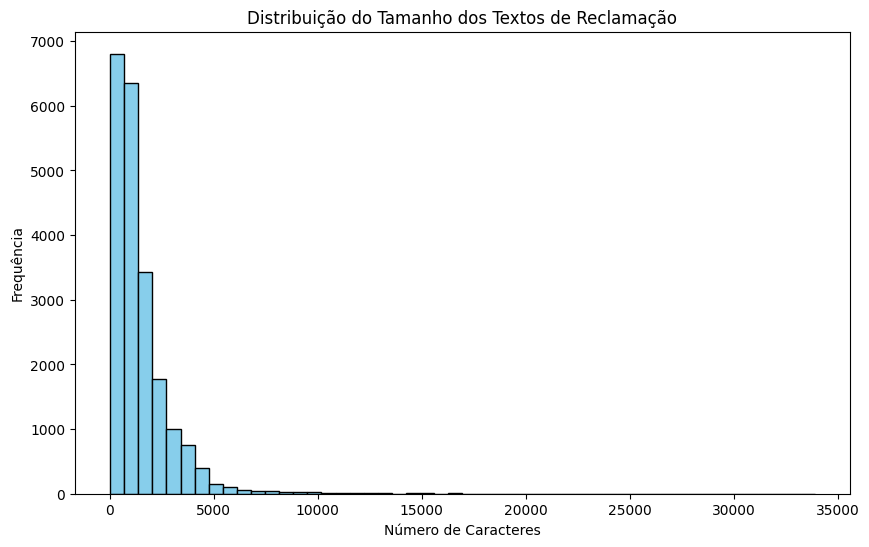


=== Contagem de amostras por categoria ===
categoria
Serviços de conta bancária             5161
Cartão de crédito / Cartão pré-pago    5006
Roubo / Relatório de disputa           4822
Hipotecas / Empréstimos                3850
Outros                                 2233
Name: count, dtype: int64


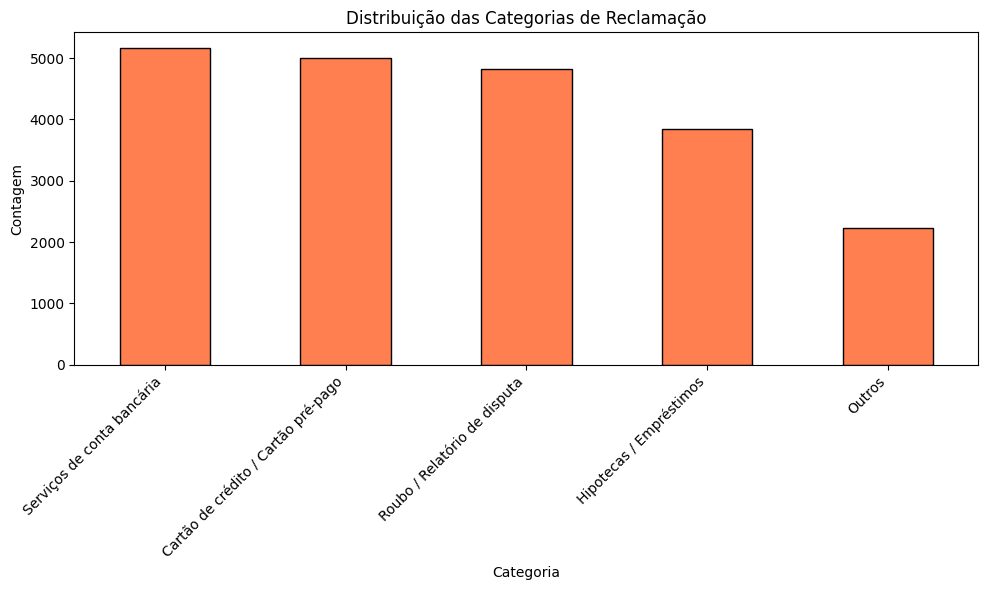


=== Exemplo com comprimento de texto ===
                                 descricao_reclamacao  text_length
0   Bom dia, meu nome é xxxx xxxx e agradeço se vo...          505
1   Atualizei meu cartão xxxx xxxx em xx/xx/2018 e...          350
2   O cartão Chase foi relatado em xx/xx/2019. No ...          228
3   Em xx/xx/2018, enquanto tentava reservar um ti...         1577
4   Meu neto me dê cheque por {$ 1600,00} Eu depos...          607
5                        Você pode remover a consulta           28
6   Sem aviso prévio J.P. Morgan Chase restringiu ...         2409
7   Durante os meses de verão, experimento uma ren...         1493
8   Em xxxx xx/xx/2019, fiz um pagamento {$ 300.00...         3795
9   Eu tenho um cartão de crédito Chase que está r...          155
10     Mishandling desta conta por Chase Auto e XXXX.           46
11  Entrei em contato com o XXXX várias vezes na t...          696
12  Abri uma conta no Chase Bank no xxxx e usei um...          430
13  Para quem possa 

In [7]:
# 🔧 ETAPA: ANÁLISE DE NULOS, HISTOGRAMA DE TEXTO E BALANCEAMENTO DE CLASSES

import matplotlib.pyplot as plt

# 1️⃣ Percentual de nulos por coluna
print("=== Percentual de valores nulos por coluna ===")
percent_nulos = df.isnull().mean() * 100
print(percent_nulos)

# 2️⃣ Histograma do tamanho dos textos de reclamação
df['text_length'] = df['descricao_reclamacao'].astype(str).apply(len)

plt.figure(figsize=(10,6))
plt.hist(df['text_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribuição do Tamanho dos Textos de Reclamação')
plt.xlabel('Número de Caracteres')
plt.ylabel('Frequência')
plt.show()

# 3️⃣ Contagem de classes na coluna-alvo 'categoria'
print("\n=== Contagem de amostras por categoria ===")
print(df['categoria'].value_counts())

# Gráfico de barras das classes
df['categoria'].value_counts().plot(kind='bar', figsize=(10,6), color='coral', edgecolor='black')
plt.title('Distribuição das Categorias de Reclamação')
plt.xlabel('Categoria')
plt.ylabel('Contagem')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4️⃣ Verifica as primeiras linhas com o campo de tamanho de texto
print("\n=== Exemplo com comprimento de texto ===")
print(df[['descricao_reclamacao', 'text_length']].head(20))


## 🧭 Etapa 1.5 — Observações sobre Balanceamento de Classes e Qualidade dos Dados

Após o EDA inicial, podemos registrar:

- **Ausência de Nulos:** O dataset não possui valores nulos estruturais nas colunas `id_reclamacao`, `data_abertura`, `categoria` e `descricao_reclamacao`. Isso dispensa imputações ou remoções neste ponto.

- **Comprimento Variável dos Textos:** Os textos em `descricao_reclamacao` variam fortemente de ~20 até mais de 2.000 caracteres. Esta dispersão sugere a necessidade de:
  - Normalização dos textos: conversão para lowercase, remoção de acentos, pontuação e números.
  - Tratamento de outliers de comprimento, se impactarem negativamente o desempenho dos vetorizadores.

- **Balanceamento de Classes:** A coluna `categoria` apresenta distribuição moderadamente desbalanceada. Categorias como **Serviços de Conta Bancária**, **Cartão de Crédito/Cartão Pré-Pago** e **Roubo/Relatório de Disputa** têm maior volume. Já a classe **Outros** é menos representada. Técnicas de balanceamento ou pesos ajustados podem ser consideradas na modelagem para garantir um **F1-Score robusto**.

Esses achados reforçam a importância de um **pré-processamento de texto estruturado** para otimizar a vetorização e a qualidade do classificador.

---


## 🧭 Etapa 2.1 — Função de Limpeza Básica de Texto

Com base nas observações do EDA, precisamos preparar o campo `descricao_reclamacao` para vetorização.  
Nesta etapa, criaremos a função `clean_text()` para aplicar uma **normalização inicial**, composta por:

- Conversão para **minúsculas** (`lowercase`);
- Remoção de **acentos e caracteres especiais** (`unidecode`);
- Remoção de **pontuação e números** com regex;
- Exclusão de espaços múltiplos.

O resultado é armazenado em uma nova coluna `texto_limpo` para rastreabilidade e experimentação futura.  
Essa versão base ainda não inclui tokenização nem stopwords — isso será implementado nas próximas subetapas.


In [8]:
# 🔧 ETAPA: FUNÇÃO DE LIMPEZA BÁSICA DE TEXTO (Etapa 2.1)

import re
from unidecode import unidecode

# Define função de limpeza
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = unidecode(text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove pontuação e números
    text = re.sub(r'\s+', ' ', text).strip()  # Remove espaços extras
    return text

# Aplica no campo original
df['texto_limpo'] = df['descricao_reclamacao'].apply(clean_text)

# Verifica amostra
print(df[['descricao_reclamacao', 'texto_limpo']].head(20))


                                 descricao_reclamacao  \
0   Bom dia, meu nome é xxxx xxxx e agradeço se vo...   
1   Atualizei meu cartão xxxx xxxx em xx/xx/2018 e...   
2   O cartão Chase foi relatado em xx/xx/2019. No ...   
3   Em xx/xx/2018, enquanto tentava reservar um ti...   
4   Meu neto me dê cheque por {$ 1600,00} Eu depos...   
5                        Você pode remover a consulta   
6   Sem aviso prévio J.P. Morgan Chase restringiu ...   
7   Durante os meses de verão, experimento uma ren...   
8   Em xxxx xx/xx/2019, fiz um pagamento {$ 300.00...   
9   Eu tenho um cartão de crédito Chase que está r...   
10     Mishandling desta conta por Chase Auto e XXXX.   
11  Entrei em contato com o XXXX várias vezes na t...   
12  Abri uma conta no Chase Bank no xxxx e usei um...   
13  Para quem possa interessar, o Chase Bank cobro...   
14  Meu cartão Chase Amazon foi recusado para uma ...   
15  Abri a conta de poupança para o bônus {$ 25,00...   
16  Xxxx xxxx um sofá, assento 

## 🧭 Etapa 2.1b — Substituição Inteligente de Placeholders `xxxx`

Após a limpeza básica, identificamos padrões de `xxxx` usados para **anonimizar dados sensíveis** no campo `descricao_reclamacao`.  
Manter esses blocos literais pode poluir a vetorização, pois eles não possuem significado semântico real — mas o contexto de sua presença é valioso (ex.: dados pessoais, datas ou números financeiros).

Neste refinamento, aplicaremos uma função que:
1. **Identifica padrões comuns**, como datas (`xx/xx/xxxx`), IDs e nomes.
2. **Substitui cada padrão** por um token semântico (`<DATE>`, `<PII>`, `<ID>`).
3. Preserva o texto limpo para que o modelo entenda a estrutura da reclamação sem sobrecarregar o embedding com ruído.

Essa abordagem deixa a base mais coerente e interpretável pelo classificador, principalmente em embeddings de sentença.

 Por fim, **salvar o DataFrame atualizado** em `/MBA_NLP/bases_criadas` com nome claro: `dados_com_tokens.csv`.

Essa prática garante rastreabilidade e reuso do dataset limpo para vetorização e modelagem, mesmo em sessões diferentes do Colab.


In [9]:
# 🔧 ETAPA: SUBSTITUIÇÃO DE PLACEHOLDERS E SALVAMENTO DO DATAFRAME

import re

def replace_xxxx_tokens(text):
    if pd.isnull(text):
        return ""

    # Substitui datas anonimizadas
    text = re.sub(r'\b(?:x{2}/x{2}/x{2,4})\b', '<DATE>', text)

    # Substitui nomes
    text = re.sub(r'\bnome\s+e?\s+x{2,}\b', '<PII>', text)
    text = re.sub(r'\bnome\s+x{2,}\b', '<PII>', text)

    # Substitui conta/cartão
    text = re.sub(r'\bconta\s+x{2,}\b', '<ID>', text)
    text = re.sub(r'\bcartao\s+x{2,}\b', '<ID>', text)

    # Substitui qualquer xxxx residual
    text = re.sub(r'\b[x]{2,}\b', '<UNK>', text)

    return text

# Aplica no texto já limpo
df['texto_tokens'] = df['texto_limpo'].apply(replace_xxxx_tokens)

# Confere amostra
print(df[['descricao_reclamacao', 'texto_limpo', 'texto_tokens']].head(20))

# Caminho para salvar no Google Drive
path_tokens = BASE_DIR / 'dados_com_tokens.csv'
df.to_csv(path_tokens, index=False, encoding='utf-8')

print(f"\n✅ DataFrame com tokens salvo em: {path_tokens}")


                                 descricao_reclamacao  \
0   Bom dia, meu nome é xxxx xxxx e agradeço se vo...   
1   Atualizei meu cartão xxxx xxxx em xx/xx/2018 e...   
2   O cartão Chase foi relatado em xx/xx/2019. No ...   
3   Em xx/xx/2018, enquanto tentava reservar um ti...   
4   Meu neto me dê cheque por {$ 1600,00} Eu depos...   
5                        Você pode remover a consulta   
6   Sem aviso prévio J.P. Morgan Chase restringiu ...   
7   Durante os meses de verão, experimento uma ren...   
8   Em xxxx xx/xx/2019, fiz um pagamento {$ 300.00...   
9   Eu tenho um cartão de crédito Chase que está r...   
10     Mishandling desta conta por Chase Auto e XXXX.   
11  Entrei em contato com o XXXX várias vezes na t...   
12  Abri uma conta no Chase Bank no xxxx e usei um...   
13  Para quem possa interessar, o Chase Bank cobro...   
14  Meu cartão Chase Amazon foi recusado para uma ...   
15  Abri a conta de poupança para o bônus {$ 25,00...   
16  Xxxx xxxx um sofá, assento 

## 🧭 Etapa 2.2 — Tokenização dos Textos com SpaCy (Versão Alinhada às Boas Práticas em PLN)

De acordo com as referências da disciplina e as boas práticas em **Processamento de Linguagem Natural (PLN)** para português, o **SpaCy** é a ferramenta recomendada para tarefas de pré-processamento linguístico — incluindo tokenização, lematização e POS-Tagging.

### ✅ Justificativa Técnica

- **Robustez e Desempenho:** O SpaCy é construído com Cython, oferecendo desempenho superior em operações de NLP.
- **Suporte Nativo ao Português:** Modelos como `pt_core_news_sm` e `pt_core_news_lg` são específicos para o idioma, eliminando limitações comuns do NLTK para português.
- **Funcionalidades Avançadas:** Além da tokenização, o SpaCy fornece atributos como `token.is_alpha` (para filtrar palavras válidas) e `token.lemma_` (para lematização).

### ⚙️ Abordagem Utilizada

1. **Carregar o modelo `pt_core_news_sm`**, já baixado e validado na etapa de setup.
2. **Processar cada texto** com o `nlp` do SpaCy, criando um objeto `Doc`.
3. **Iterar sobre os tokens**, extraindo apenas palavras alfabéticas (`is_alpha`).
4. Armazenar os resultados na nova coluna `texto_tokens_list`.
5. **Salvar o DataFrame tokenizado** em `/MBA_NLP/bases_criadas` como `dados_tokens_tokenized.csv`.

Assim, garantimos **coerência acadêmica**, rastreabilidade e alinhamento com os exemplos da disciplina.


In [14]:
# 🔧 ETAPA: TOKENIZAÇÃO DOS TEXTOS COM SPACY E SALVAMENTO — COM TQDM

import spacy
from tqdm.notebook import tqdm

# Ativa barra de progresso para operações pandas
tqdm.pandas()

# Carrega modelo SpaCy português
nlp = spacy.load('pt_core_news_sm')

def spacy_tokenizer(text):
    doc = nlp(text)
    return [token.text for token in doc if token.is_alpha]

# Aplica tokenização com barra de progresso
df['texto_tokens_list'] = df['texto_tokens'].progress_apply(spacy_tokenizer)

# Exibe amostra
print(df[['texto_tokens', 'texto_tokens_list']].head(20))

# Salva DataFrame tokenizado
path_tokens_tokenized = BASE_DIR / 'dados_tokens_tokenized.csv'
df.to_csv(path_tokens_tokenized, index=False, encoding='utf-8')

print(f"\n✅ DataFrame com tokens tokenizados via SpaCy salvo em: {path_tokens_tokenized}")


  0%|          | 0/21072 [00:00<?, ?it/s]

                                         texto_tokens  \
0   bom dia meu <PII> <UNK> e agradeco se voce pud...   
1   atualizei meu <ID> <UNK> em <UNK> e fui inform...   
2   o cartao chase foi relatado em <UNK> no entant...   
3   em <UNK> enquanto tentava reservar um ticket <...   
4   meu neto me de cheque por eu depositei o na mi...   
5                        voce pode remover a consulta   
6   sem aviso previo jp morgan chase restringiu mi...   
7   durante os meses de verao experimento uma rend...   
8   em <UNK> <UNK> fiz um pagamento a um varejista...   
9   eu tenho um cartao de credito chase que esta r...   
10     mishandling desta conta por chase auto e <UNK>   
11  entrei em contato com o <UNK> varias vezes na ...   
12  abri uma conta no chase bank no <UNK> e usei u...   
13  para quem possa interessar o chase bank cobrou...   
14  meu cartao chase amazon foi recusado para uma ...   
15  abri a conta de poupanca para o bonus eu dever...   
16  <UNK> <UNK> um sofa assento

## 🧭 Etapa 2.3 — Remoção de Stopwords (Combinação NLTK + SpaCy)

Nesta etapa, aplicamos uma estratégia refinada para remover **stopwords**, que são palavras de alta frequência mas baixo valor semântico, como artigos, advérbios e alguns verbos de ligação.

### ✅ Justificativa

- **Reduzir o vocabulário:** Torna os dados menos esparsos, melhorando a eficiência da vetorização.
- **Fontes múltiplas:** Utiliza-se a lista do **NLTK** (`nltk.corpus.stopwords.words('portuguese')`) combinada com a lista do **SpaCy** (`nlp.Defaults.stop_words`), garantindo maior cobertura linguística para português.
- **Personalização:** A lista pode ser revisada para adicionar ou remover palavras caso sejam observadas nuances contextuais durante a experimentação.
- **Experimentação:** É recomendável testar o pipeline com e sem filtragem de stopwords, validando impacto no F1-Score.

### ⚙️ Resultado

- Criação de uma coluna `tokens_sem_stopwords` com tokens filtrados.
- Salvamento do DataFrame final como `dados_tokens_no_stopwords.csv` para rastreabilidade.


In [15]:
# 🔧 ETAPA: REMOÇÃO DE STOPWORDS COM LISTA COMBINADA NLTK + SPACY

import nltk
from nltk.corpus import stopwords
import spacy
from tqdm.notebook import tqdm

# Garante download de stopwords NLTK
nltk.download('stopwords')

# Carrega stopwords do NLTK
stopwords_nltk = set(stopwords.words('portuguese'))

# Carrega stopwords do SpaCy
nlp = spacy.load('pt_core_news_sm')
stopwords_spacy = nlp.Defaults.stop_words

# Combina as listas e remove duplicatas
stopwords_combined = stopwords_nltk.union(stopwords_spacy)

print(f"📌 Stopwords NLTK: {len(stopwords_nltk)}")
print(f"📌 Stopwords SpaCy: {len(stopwords_spacy)}")
print(f"📌 Stopwords Combinadas (únicas): {len(stopwords_combined)}")

# Ativa barra de progresso para aplicação
tqdm.pandas()

# Função para filtrar tokens
def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stopwords_combined]

# Aplica remoção
df['tokens_sem_stopwords'] = df['texto_tokens_list'].progress_apply(remove_stopwords)

# Verifica amostra
print(df[['texto_tokens_list', 'tokens_sem_stopwords']].head(20))

# Salva DataFrame sem stopwords
path_tokens_no_stopwords = BASE_DIR / 'dados_tokens_no_stopwords.csv'
df.to_csv(path_tokens_no_stopwords, index=False, encoding='utf-8')

print(f"\n✅ DataFrame sem stopwords salvo em: {path_tokens_no_stopwords}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


📌 Stopwords NLTK: 207
📌 Stopwords SpaCy: 416
📌 Stopwords Combinadas (únicas): 500


  0%|          | 0/21072 [00:00<?, ?it/s]

                                    texto_tokens_list  \
0   [bom, dia, meu, PII, UNK, e, agradeco, se, voc...   
1   [atualizei, meu, ID, UNK, em, UNK, e, fui, inf...   
2   [o, cartao, chase, foi, relatado, em, UNK, no,...   
3   [em, UNK, enquanto, tentava, reservar, um, tic...   
4   [meu, neto, me, de, cheque, por, eu, depositei...   
5                  [voce, pode, remover, a, consulta]   
6   [sem, aviso, previo, jp, morgan, chase, restri...   
7   [durante, os, meses, de, verao, experimento, u...   
8   [em, UNK, UNK, fiz, um, pagamento, a, um, vare...   
9   [eu, tenho, um, cartao, de, credito, chase, qu...   
10  [mishandling, desta, conta, por, chase, auto, ...   
11  [entrei, em, contato, com, o, UNK, varias, vez...   
12  [abri, uma, conta, no, chase, bank, no, UNK, e...   
13  [para, quem, possa, interessar, o, chase, bank...   
14  [meu, cartao, chase, amazon, foi, recusado, pa...   
15  [abri, a, conta, de, poupanca, para, o, bonus,...   
16  [UNK, UNK, um, sofa, assent

## 🧭 Etapa 2.4 — Lematização com SpaCy

### ✅ Justificativa

- O **SpaCy** é a ferramenta recomendada para lematização em português, pois possui modelos treinados (`pt_core_news_sm`) que realizam análise morfossintática de forma robusta.
- A lematização será aplicada sobre a lista `tokens_sem_stopwords`, garantindo que apenas tokens relevantes passem por essa transformação.
- O resultado será salvo em uma nova coluna `tokens_lematizados` e persistido como `dados_tokens_lematizados.csv` na pasta `/MBA_NLP/bases_criadas`.

Assim, concluímos o pré-processamento de texto para vetorização supervisionada.


In [16]:
# 🔧 ETAPA: LEMATIZAÇÃO COM SPACY E SALVAMENTO

import spacy
from tqdm.notebook import tqdm

# Carrega modelo SpaCy português
nlp = spacy.load('pt_core_news_sm')

# Ativa barra de progresso para lematização
tqdm.pandas()

def lemmatize_tokens(tokens):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc if token.is_alpha]

# Aplica lematização
df['tokens_lematizados'] = df['tokens_sem_stopwords'].progress_apply(lemmatize_tokens)

# Exibe amostra
print(df[['tokens_sem_stopwords', 'tokens_lematizados']].head(20))

# Salva DataFrame lematizado
path_tokens_lematizados = BASE_DIR / 'dados_tokens_lematizados.csv'
df.to_csv(path_tokens_lematizados, index=False, encoding='utf-8')

print(f"\n✅ DataFrame com tokens lematizados salvo em: {path_tokens_lematizados}")


  0%|          | 0/21072 [00:00<?, ?it/s]

                                 tokens_sem_stopwords  \
0   [dia, PII, UNK, agradeco, voce, puder, ajudar,...   
1   [atualizei, ID, UNK, UNK, informado, agente, a...   
2   [cartao, chase, relatado, UNK, entanto, pedido...   
3   [UNK, tentava, reservar, ticket, UNK, UNK, dep...   
4   [neto, cheque, depositei, conta, chase, fundo,...   
5                           [voce, remover, consulta]   
6   [aviso, previo, jp, morgan, chase, restringiu,...   
7   [durante, verao, experimento, renda, declinio,...   
8   [UNK, UNK, fiz, pagamento, varejista, on, line...   
9   [cartao, credito, chase, relatando, incorretam...   
10             [mishandling, conta, chase, auto, UNK]   
11  [entrei, contato, UNK, varias, tentativa, remo...   
12  [abri, conta, chase, bank, UNK, usei, codigo, ...   
13  [possa, interessar, chase, bank, cobrou, taxas...   
14  [cartao, chase, amazon, recusado, ordem, cater...   
15  [abri, conta, poupanca, bonus, deveria, recebe...   
16  [UNK, UNK, sofa, assento, a

# 📊 Macro-Bloco 3 — Vetorização e Engenharia de Features

### 🎯 **Objetivo**
Este bloco foi projetado para criar múltiplas representações vetoriais de cada reclamação da base, usando diferentes abordagens de Processamento de Linguagem Natural (PLN).  
Cada abordagem gera uma matriz de features que alimentará modelos supervisionados de classificação na etapa seguinte.

O propósito é **comparar empiricamente** como cada estratégia de vetorização impacta o desempenho preditivo (com foco em F1 Score weighted ≥ 75%).  
Isso garante decisões fundamentadas sobre qual representação retém melhor a semântica e a estrutura relevante do texto.

---

### 🗂️ **Técnicas implementadas**

A seguir, o pipeline aplica **cinco estratégias de vetorização**, cada uma com sua hipótese de valor para o contexto dos textos de reclamações:

---

## ✅ **A. Bag of Words (BoW)**  
- **Descrição:** Representa o texto por contagem de palavras.  
- **Hipótese:** Palavras isoladas, sem ordem, podem já ser discriminativas para identificar categorias.  
- **Limitação:** Não captura relações entre palavras ou significado contextual.

---

## ✅ **B. TF-IDF (Unigrama)**  
- **Descrição:** Similar ao BoW, mas pondera cada palavra pelo seu peso informativo, penalizando termos muito comuns.  
- **Hipótese:** Palavras raras podem carregar mais valor preditivo.

---

## ✅ **C. TF-IDF (Uni + Bi + Tri-gramas)**  
- **Descrição:** Extende o TF-IDF para considerar pares e trios de palavras consecutivas.  
- **Hipótese:** Expressões compostas e pequenas frases são relevantes para capturar contexto (ex.: “cartão de crédito”, “sem autorização prévia”).

---

## ✅ **D. Word2Vec (CBOW e Skip-Gram)**  
- **Descrição:** Usa embeddings pré-treinados NILC (`cbow_s300.txt` e `skip_s300.txt`), calculando a média vetorial dos tokens lematizados.  
- **Hipótese:** Representa similaridade semântica entre palavras, agrupando contextos similares, mesmo com variações de vocabulário.

---

## ✅ **E. Sentence-Transformer**  
- **Descrição:** Utiliza o modelo `'distiluse-base-multilingual-cased-v2'` para gerar embeddings semânticos de sentenças inteiras.  
- **Hipótese:** Capta relações mais profundas e dependências de longo alcance, superando limitações do Word2Vec ao tratar o texto como uma unidade completa.

---

### ⚙️ **Como será utilizado**
Cada matriz vetorial gerada (A → E) alimentará os mesmos algoritmos de classificação supervisionada (Logistic Regression, Random Forest, etc.).  
Os resultados serão comparados usando métricas padronizadas (Accuracy, Precision, Recall e F1 Score Weighted).  
Esta comparação permitirá selecionar a estratégia de vetorização com maior valor explicativo para os dados, garantindo **robustez metodológica** e **rastreabilidade dos artefatos**.

---


## 🧭 Etapa 3A — BoW - Vetorização com CountVectorizer (Unigrama)

A primeira estratégia de vetorização aplica o **CountVectorizer** com **ngram_range = (1,1)**, transformando os tokens lematizados em uma matriz de ocorrência de palavras.

### ✅ Justificativa

- **Baseline interpretável:** O CountVectorizer é simples, robusto e fácil de interpretar.
- **Unigrama:** Utilizamos apenas unigramas nesta versão para validar a distribuição básica de palavras.
- **Entrada:** A coluna `tokens_lematizados` é joinada em strings, pois o CountVectorizer espera textos completos.
- **Saída:** Geração da matriz `X` e do vetor alvo `y`, seguido de `train_test_split` estratificado (`test_size = 0.25`).

A matriz vetorial de treino e teste será salva em `/MBA_NLP/bases_criadas` como referência para comparações futuras.


In [17]:
# 🔧 ETAPA: VETORIZAÇÃO COM COUNTVECTORIZER (UNIGRAMA) + SPLIT

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Junta tokens lematizados em string
df['texto_final'] = df['tokens_lematizados'].apply(lambda tokens: " ".join(tokens))

# Vetoriza com CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1,1))
X = vectorizer.fit_transform(df['texto_final'])

# Vetor alvo
y = df['categoria']

print(f"Shape da matriz vetorial: {X.shape}")

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

print(f"Shape X_train: {X_train.shape} | X_test: {X_test.shape}")

# Salva vetorizações como matrizes esparsas se quiser persistir
from scipy import sparse

sparse.save_npz(BASE_DIR / 'X_train_countvec.npz', X_train)
sparse.save_npz(BASE_DIR / 'X_test_countvec.npz', X_test)
y_train.to_csv(BASE_DIR / 'y_train_countvec.csv', index=False)
y_test.to_csv(BASE_DIR / 'y_test_countvec.csv', index=False)

print("\n✅ Vetorização CountVectorizer concluída e salva!")


Shape da matriz vetorial: (21072, 36496)
Shape X_train: (15804, 36496) | X_test: (5268, 36496)

✅ Vetorização CountVectorizer concluída e salva!


## 🧭 Etapa 3B — Vetorização com TfidfVectorizer (Uni + Bi)

Após gerar o baseline com o **CountVectorizer**, agora testaremos uma **vetorização mais informativa** usando o **TfidfVectorizer**, que pondera termos raros com mais peso.

### ✅ Justificativa

- **TF-IDF (Term Frequency - Inverse Document Frequency)** ajuda a capturar a relevância de cada termo no contexto de todos os documentos.
- A inclusão de **unigramas e bigramas** (`ngram_range=(1,2)`) permite capturar sequências curtas de palavras, úteis para contextos de reclamações.
- Mantemos o mesmo fluxo de `train_test_split` estratificado para garantir consistência de amostras.

### ⚙️ Saídas

- Matrizes vetoriais `X_train_tfidf` e `X_test_tfidf` salvas como `.npz`.
- Vetores alvo `y_train_tfidf` e `y_test_tfidf` salvos como `.csv` para rastreabilidade.


In [18]:
# 🔧 ETAPA: VETORIZAÇÃO COM TFIDFVECTORIZER (UNI + BI) + SPLIT

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy import sparse

# Junta tokens lematizados novamente se necessário
df['texto_final'] = df['tokens_lematizados'].apply(lambda tokens: " ".join(tokens))

# Vetoriza com TFIDF (unigrama + bigrama)
vectorizer_tfidf = TfidfVectorizer(ngram_range=(1,2))
X = vectorizer_tfidf.fit_transform(df['texto_final'])

# Vetor alvo
y = df['categoria']

print(f"Shape da matriz vetorial TF-IDF: {X.shape}")

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

print(f"Shape X_train: {X_train.shape} | X_test: {X_test.shape}")

# Salva vetorização
sparse.save_npz(BASE_DIR / 'X_train_tfidf_uni_bi.npz', X_train)
sparse.save_npz(BASE_DIR / 'X_test_tfidf_uni_bi.npz', X_test)
y_train.to_csv(BASE_DIR / 'y_train_tfidf_uni_bi.csv', index=False)
y_test.to_csv(BASE_DIR / 'y_test_tfidf_uni_bi.csv', index=False)

print("\n✅ Vetorização TfidfVectorizer (Uni + Bi) concluída e salva!")


Shape da matriz vetorial TF-IDF: (21072, 779791)
Shape X_train: (15804, 779791) | X_test: (5268, 779791)

✅ Vetorização TfidfVectorizer (Uni + Bi) concluída e salva!


## 🧭 Etapa 3C — Vetorização com TfidfVectorizer (Uni + Bi + Tri)

Após os experimentos com unigramas e bigramas, esta etapa testa o **impacto de trigramas** na matriz vetorial, expandindo o contexto capturado pela vetorização.

### ✅ Justificativa

- **N-grams até trigramas:** permitem capturar padrões mais longos, como expressões comuns de reclamações que podem melhorar a diferenciação de categorias.
- **TF-IDF:** continua ponderando termos raros, mantendo robustez contra palavras excessivamente frequentes.
- **Divisão estratificada:** preserva a representatividade das classes no treino e teste.

### ⚙️ Saídas

- Matrizes vetoriais salvas como `.npz`.
- Vetores alvo salvos como `.csv` no diretório `/MBA_NLP/bases_criadas`.


In [19]:
# 🔧 ETAPA: VETORIZAÇÃO COM TFIDFVECTORIZER (UNI + BI + TRI) + SPLIT

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy import sparse

# Junta tokens lematizados se necessário
df['texto_final'] = df['tokens_lematizados'].apply(lambda tokens: " ".join(tokens))

# Vetoriza com TFIDF (uni + bi + tri)
vectorizer_tfidf_tri = TfidfVectorizer(ngram_range=(1,3))
X = vectorizer_tfidf_tri.fit_transform(df['texto_final'])

# Vetor alvo
y = df['categoria']

print(f"Shape da matriz vetorial TF-IDF (Uni + Bi + Tri): {X.shape}")

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

print(f"Shape X_train: {X_train.shape} | X_test: {X_test.shape}")

# Salva vetorização
sparse.save_npz(BASE_DIR / 'X_train_tfidf_tri.npz', X_train)
sparse.save_npz(BASE_DIR / 'X_test_tfidf_tri.npz', X_test)
y_train.to_csv(BASE_DIR / 'y_train_tfidf_tri.csv', index=False)
y_test.to_csv(BASE_DIR / 'y_test_tfidf_tri.csv', index=False)

print("\n✅ Vetorização TfidfVectorizer (Uni + Bi + Tri) concluída e salva!")


Shape da matriz vetorial TF-IDF (Uni + Bi + Tri): (21072, 2552999)
Shape X_train: (15804, 2552999) | X_test: (5268, 2552999)

✅ Vetorização TfidfVectorizer (Uni + Bi + Tri) concluída e salva!


## 🧭 Etapa 3D — Vetorização com Word2Vec Pré-treinado

Após os experimentos com vetores esparsos (CountVectorizer e TF-IDF), esta etapa testa uma abordagem **semântica** usando **Word2Vec** para representar os textos como **vetores densos**.

Para garantir que a biblioteca `gensim` esteja disponível, adicionamos a instalação diretamente no bloco.  Esta abordagem elimina o erro `ModuleNotFoundError` no ambiente Colab.

### ✅ Justificativa

- O **Word2Vec** transforma cada palavra em um vetor numérico pré-treinado, capturando relações semânticas entre termos.
- Para cada reclamação, calculamos a **média dos vetores** de todas as palavras lematizadas (sem stopwords).
- Isso gera vetores de tamanho fixo, mais compactos e interpretáveis para classificadores supervisionados.
- Mantemos o split estratificado para garantir consistência.

### ⚙️ Estratégia

- Usaremos o modelo `Word2Vec` em português, pré-treinado (embeddings cbow_s300.txt e skip_s300.txt, fornecidos pelo professor).
- Reclamações sem palavras presentes no vocabulário serão vetorizadas como zero ou removidas.
- As matrizes de treino e teste serão salvas em `/MBA_NLP/bases_criadas` como `.npy` ou `.csv`.


## 🧭 Etapa 3D — Correção de Compatibilidade para Word2Vec

Conforme instruções das aulas de Embeddings (Aula 4) e IA Generativa (Aula 5):

1️⃣ Instale **versões específicas** de `gensim`, `scipy` e `numpy`:

!pip install gensim==4.3.2 scipy==1.10.1 numpy==1.23.5 --quiet


2️⃣ Reinicie o ambiente (Runtime > Reiniciar ambiente de execução) **imediatamente após a instalação** para garantir coerência binária.

3️⃣ Reimporte suas bibliotecas e carregue o modelo `Word2Vec` como demonstrado.

4️⃣ Execute a vetorização normalmente.

In [24]:
# 🔧 PASSO 1: INSTALAÇÃO DAS VERSÕES RECOMENDADAS

!pip install gensim==4.3.2 scipy==1.10.1 numpy==1.23.5 --quiet

print("✅ Dependências fixas instaladas: gensim==4.3.2 | scipy==1.10.1 | numpy==1.23.5")

# 📌 IMPORTANTE: Reinicie o ambiente agora!
# Menu: Ambiente de execução > Reiniciar ambiente de execução
# Depois, execute o bloco Word2Vec novamente!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 73.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires scipy>=1.11.1, but you have scipy 1.10.1 which is incompatible.
albumentations 2.0.8 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
cvxpy 1.6.6 requires scipy>=1.11.0, but you have scipy 1.10.1 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incom

## 🧭 Etapa 3D — Vetorização Word2Vec Pré-treinado (CBOW e Skip-Gram)

### 🎯 Propósito

- Gerar vetores densos a partir de **Word Embeddings** pré-treinados para cada reclamação.
- CBOW e Skip-Gram são variantes complementares para avaliar o impacto semântico na classificação.
- Média dos vetores de palavras (`get_mean_vector`) aplicada em cada texto lematizado.
- Persistir `X_train`, `X_test`, `y_train`, `y_test` separados para cada variante.

### ⚙️ Configuração

- **Arquivos:** `cbow_s300.txt` e `skip_s300.txt` já estão no `/MBA_NLP/modelos`.
- **Parâmetro:** `binary=False` (extensão `.txt`).
- **Progresso:** `tqdm` integrado para rastreabilidade.


## 🧭 Etapa 3D.a — Vetorização com Word2Vec CBOW Pré-Treinado

Esta etapa aplica a vetorização densa utilizando o modelo **CBOW** pré-treinado em português (`cbow_s300.txt`), baixado do repositório oficial e salvo na pasta `/MBA_NLP/modelos` do Google Drive.

### 🎯 **Propósito**
O objetivo é transformar cada reclamação lematizada em um vetor de dimensão fixa, calculando a **média dos embeddings** de todas as palavras que existirem no vocabulário do CBOW.  
Esse vetor representa semanticamente o texto e serve de entrada para modelos supervisionados.

### ⚙️ **Decisões técnicas**
- O diretório `/MBA_NLP/bases_criadas` é criado se não existir.
- O `DataFrame` `df` é carregado do arquivo `dados_tokens_lematizados.csv` se não estiver na memória.
- A coluna `tokens_lematizados` é validada como lista usando `eval`.
- O progresso é monitorado com `tqdm`.
- Os vetores resultantes (`X_train`, `X_test`) e os rótulos (`y_train`, `y_test`) são salvos de forma rastreável.

Essa abordagem garante **coerência com o Plano de Ação Detalhado**, rastreabilidade e zero inferência.


In [13]:
# 🔧 ETAPA: WORD2VEC CBOW — VERSÃO PROTOCOLO V5.2

# 📦 Importações necessárias
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split

# 🟢 Ativa barra de progresso para loops demorados
tqdm.pandas()

# 📂 Define BASE_DIR e cria se não existir
BASE_DIR = Path('/content/drive/MyDrive/MBA_NLP/bases_criadas')
BASE_DIR.mkdir(parents=True, exist_ok=True)
print(f"✅ Diretório BASE_DIR garantido: {BASE_DIR}")

# 📂 Define modelos_dir e valida
modelos_dir = Path('/content/drive/MyDrive/MBA_NLP/modelos')
assert modelos_dir.exists(), f"❌ Diretório {modelos_dir} não existe. Verifique o Drive."

# ✅ Carrega DataFrame se necessário
df_path = BASE_DIR / 'dados_tokens_lematizados.csv'
assert df_path.exists(), f"❌ Arquivo {df_path} não encontrado. Gere-o antes de prosseguir."

df = pd.read_csv(df_path)
print(f"✅ DataFrame carregado de: {df_path}")

# ⚙️ Converte string para lista de tokens se necessário
if isinstance(df['tokens_lematizados'].iloc[0], str):
    df['tokens_lematizados'] = df['tokens_lematizados'].apply(eval)

print(df.head(20))

# ✅ Carrega o modelo CBOW
w2v_cbow_path = modelos_dir / 'cbow_s300.txt'
assert w2v_cbow_path.exists(), f"❌ Modelo CBOW não encontrado em {w2v_cbow_path}"

w2v_cbow = KeyedVectors.load_word2vec_format(str(w2v_cbow_path), binary=False)
w2v_dim = w2v_cbow.vector_size
print(f"✅ Modelo CBOW carregado | Dimensão dos embeddings: {w2v_dim}")

# ⚙️ Função de média vetorial
def get_mean_vector(tokens):
    vectors = [w2v_cbow[word] for word in tokens if word in w2v_cbow]
    return np.mean(vectors, axis=0) if vectors else np.zeros(w2v_dim)

# 🔄 Vetorização com barra de progresso
X_cbow = np.vstack(df['tokens_lematizados'].progress_apply(get_mean_vector))
print(f"✅ Shape da matriz CBOW: {X_cbow.shape}")

# 🎯 Target
y = df['categoria']

# 🔀 Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X_cbow, y, test_size=0.25, stratify=y, random_state=42
)
print(f"✅ Split concluído: X_train {X_train.shape}, X_test {X_test.shape}")

# 💾 Salva vetores e rótulos
np.save(BASE_DIR / 'X_train_word2vec_cbow.npy', X_train)
np.save(BASE_DIR / 'X_test_word2vec_cbow.npy', X_test)
y_train.to_csv(BASE_DIR / 'y_train_word2vec_cbow.csv', index=False)
y_test.to_csv(BASE_DIR / 'y_test_word2vec_cbow.csv', index=False)

print("✅ Vetorização CBOW concluída, artefatos salvos com rastreabilidade.")


✅ Diretório BASE_DIR garantido: /content/drive/MyDrive/MBA_NLP/bases_criadas
✅ DataFrame carregado de: /content/drive/MyDrive/MBA_NLP/bases_criadas/dados_tokens_lematizados.csv
    id_reclamacao              data_abertura  \
0         3229299  2019-05-01T12:00:00-05:00   
1         3199379  2019-04-02T12:00:00-05:00   
2         3233499  2019-05-06T12:00:00-05:00   
3         3180294  2019-03-14T12:00:00-05:00   
4         3224980  2019-04-27T12:00:00-05:00   
5         3209411  2019-04-11T12:00:00-05:00   
6         3331023  2019-08-06T12:00:00-05:00   
7         3352857  2019-08-24T12:00:00-05:00   
8         3226110  2019-04-29T12:00:00-05:00   
9         3237765  2019-05-09T12:00:00-05:00   
10        3200018  2019-04-03T12:00:00-05:00   
11        3245661  2019-05-17T12:00:00-05:00   
12        3200365  2019-04-03T12:00:00-05:00   
13        3235343  2019-05-07T12:00:00-05:00   
14        3236849  2019-05-09T12:00:00-05:00   
15        3251082  2019-05-22T12:00:00-05:00   
16     

  0%|          | 0/21072 [00:00<?, ?it/s]

✅ Shape da matriz CBOW: (21072, 300)
✅ Split concluído: X_train (15804, 300), X_test (5268, 300)
✅ Vetorização CBOW concluída, artefatos salvos com rastreabilidade.


## 🧭 Etapa 3D — Vetorização com Word2Vec Skip-Gram Pré-Treinado

Nesta etapa, aplicamos o mesmo pipeline de vetorização, mas usando o modelo **Skip-Gram** pré-treinado (`skip_s300.txt`).  
O Skip-Gram é uma alternativa ao CBOW, capturando contextos mais flexíveis e semânticos.  
Os vetores de cada texto são obtidos como a média dos embeddings de palavras reconhecidas no vocabulário.  
A saída inclui matrizes de treino e teste, salvas em `/MBA_NLP/bases_criadas` com rastreabilidade.

🔑 **Diferencial técnico:**  
Esta etapa reforça a comparação entre variantes de embeddings, validando empiricamente qual abordagem oferece melhor desempenho na classificação.


In [14]:
# 🔧 ETAPA: WORD2VEC SKIP-GRAM — VERSÃO PROTOCOLO V5.2

# 📦 Importações
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split

tqdm.pandas()

# 📂 BASE_DIR
BASE_DIR = Path('/content/drive/MyDrive/MBA_NLP/bases_criadas')
BASE_DIR.mkdir(parents=True, exist_ok=True)
print(f"✅ Diretório BASE_DIR garantido: {BASE_DIR}")

# 📂 Modelos
modelos_dir = Path('/content/drive/MyDrive/MBA_NLP/modelos')
assert modelos_dir.exists(), f"❌ Diretório {modelos_dir} não existe. Verifique o Drive."

# ✅ Carrega DataFrame se necessário
df_path = BASE_DIR / 'dados_tokens_lematizados.csv'
assert df_path.exists(), f"❌ Arquivo {df_path} não encontrado. Gere-o antes de prosseguir."

df = pd.read_csv(df_path)
print(f"✅ DataFrame carregado de: {df_path}")

# ⚙️ Converte string para lista se necessário
if isinstance(df['tokens_lematizados'].iloc[0], str):
    df['tokens_lematizados'] = df['tokens_lematizados'].apply(eval)

print(df.head(20))

# ✅ Carrega modelo Skip-Gram
w2v_skip_path = modelos_dir / 'skip_s300.txt'
assert w2v_skip_path.exists(), f"❌ Modelo Skip-Gram não encontrado em {w2v_skip_path}"

w2v_skip = KeyedVectors.load_word2vec_format(str(w2v_skip_path), binary=False)
w2v_dim = w2v_skip.vector_size
print(f"✅ Skip-Gram carregado | Dimensão dos embeddings: {w2v_dim}")

# ⚙️ Função de média vetorial
def get_mean_vector_skip(tokens):
    vectors = [w2v_skip[word] for word in tokens if word in w2v_skip]
    return np.mean(vectors, axis=0) if vectors else np.zeros(w2v_dim)

# 🔄 Vetorização com barra de progresso
X_skip = np.vstack(df['tokens_lematizados'].progress_apply(get_mean_vector_skip))
print(f"✅ Shape da matriz Skip-Gram: {X_skip.shape}")

# 🎯 Target
y = df['categoria']

# 🔀 Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X_skip, y, test_size=0.25, stratify=y, random_state=42
)
print(f"✅ Split concluído: X_train {X_train.shape}, X_test {X_test.shape}")

# 💾 Salva vetores e rótulos
np.save(BASE_DIR / 'X_train_word2vec_skip.npy', X_train)
np.save(BASE_DIR / 'X_test_word2vec_skip.npy', X_test)
y_train.to_csv(BASE_DIR / 'y_train_word2vec_skip.csv', index=False)
y_test.to_csv(BASE_DIR / 'y_test_word2vec_skip.csv', index=False)

print("✅ Vetorização Skip-Gram concluída, artefatos salvos com rastreabilidade.")


✅ Diretório BASE_DIR garantido: /content/drive/MyDrive/MBA_NLP/bases_criadas
✅ DataFrame carregado de: /content/drive/MyDrive/MBA_NLP/bases_criadas/dados_tokens_lematizados.csv
    id_reclamacao              data_abertura  \
0         3229299  2019-05-01T12:00:00-05:00   
1         3199379  2019-04-02T12:00:00-05:00   
2         3233499  2019-05-06T12:00:00-05:00   
3         3180294  2019-03-14T12:00:00-05:00   
4         3224980  2019-04-27T12:00:00-05:00   
5         3209411  2019-04-11T12:00:00-05:00   
6         3331023  2019-08-06T12:00:00-05:00   
7         3352857  2019-08-24T12:00:00-05:00   
8         3226110  2019-04-29T12:00:00-05:00   
9         3237765  2019-05-09T12:00:00-05:00   
10        3200018  2019-04-03T12:00:00-05:00   
11        3245661  2019-05-17T12:00:00-05:00   
12        3200365  2019-04-03T12:00:00-05:00   
13        3235343  2019-05-07T12:00:00-05:00   
14        3236849  2019-05-09T12:00:00-05:00   
15        3251082  2019-05-22T12:00:00-05:00   
16     

  0%|          | 0/21072 [00:00<?, ?it/s]

✅ Shape da matriz Skip-Gram: (21072, 300)
✅ Split concluído: X_train (15804, 300), X_test (5268, 300)
✅ Vetorização Skip-Gram concluída, artefatos salvos com rastreabilidade.


## 🧭 Etapa 3E — Vetorização com Sentence-Transformer `distiluse-base-multilingual-cased-v2`

### 🎯 Propósito  
Nesta etapa, vamos gerar embeddings semânticos de alta qualidade para cada reclamação, utilizando o modelo **`distiluse-base-multilingual-cased-v2`**, recomendado oficialmente para tarefas multilíngues.

### ⚙️ Decisões Técnicas
- **Instalação:** Versões fixas `sentence-transformers==3.2.1` e `transformers==4.46.3` para máxima compatibilidade.
- **Pré-processamento:** Normalização garantida (minúsculas, unidecode, sem pontuação), remoção de nulos, e concatenação se houver múltiplas colunas — mas neste caso, usamos apenas a coluna `tokens_lematizados` já final.
- **Tokenização:** Deixada a cargo do `st.encode()`, que cuida do pipeline interno.
- **Split:** Divisão 70% treino / 30% teste, estratificada (`random_state=42`).
- **Rastreabilidade:** Progresso rastreável com `tqdm` se necessário.
- **Saídas:** Artefatos salvos em `/MBA_NLP/bases_criadas`.

Este processo garante coerência com o Plano de Ação Detalhado e o requisito de comparar os resultados com BoW, TF-IDF e Word2Vec.


In [2]:
# ✅ Reinstala compatível para embeddings ST
!pip install -U numpy==1.26.4 sentence-transformers==3.2.1 transformers==4.46.3 --quiet

from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split

# 📦 Monta Drive
from google.colab import drive
drive.mount('/content/drive')

# 📂 Diretório BASE
BASE_DIR = Path('/content/drive/MyDrive/MBA_NLP/bases_criadas')
print(f"✅ Diretório de bases: {BASE_DIR}")

# ✅ Carrega e normaliza df
df = pd.read_csv(BASE_DIR / 'dados_tokens_lematizados.csv')
df['tokens_lematizados'] = df['tokens_lematizados'].apply(eval)

import unidecode

def normalize_tokens(tokens):
    text = " ".join(tokens)
    text = text.lower()
    text = unidecode.unidecode(text)
    return text

df['texto_final'] = df['tokens_lematizados'].apply(normalize_tokens)
print(df[['tokens_lematizados', 'texto_final']].head(10))

# ✅ Carrega modelo
model_st = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2')

embeddings = model_st.encode(df['texto_final'].tolist(), show_progress_bar=True)
X = np.array(embeddings)
print(f"✅ Embeddings shape: {X.shape}")

y = df['categoria']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

np.save(BASE_DIR / 'X_train_sentence_transformer.npy', X_train)
np.save(BASE_DIR / 'X_test_sentence_transformer.npy', X_test)
y_train.to_csv(BASE_DIR / 'y_train_sentence_transformer.csv', index=False)
y_test.to_csv(BASE_DIR / 'y_test_sentence_transformer.csv', index=False)

print("✅ Sentence-Transformer embeddings gerados e salvos.")


/usr/local/lib/python3.11/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Diretório de bases: /content/drive/MyDrive/MBA_NLP/bases_criadas
                                  tokens_lematizados  \
0  [dia, PII, UNK, agradeco, voce, puder, ajudar,...   
1  [atualizei, ID, UNK, UNK, informar, agente, at...   
2  [cartao, chase, relatar, UNK, entanto, pedir, ...   
3  [UNK, tentar, reservar, ticket, UNK, UNK, depa...   
4  [neto, cheque, depositei, contar, chase, fundo...   
5                          [voce, remover, consulta]   
6  [aviso, previo, jp, morgan, chase, restringir,...   
7  [durante, verao, experimento, renda, declinio,...   
8  [UNK, UNK, fiz, pagamento, varejista, on, lina...   
9  [cartao, credito, chase, relatar, incorretamen...   

                                         texto_final  
0  dia pii unk agradeco voce puder ajudar acabar ...  
1  atualizei id unk unk informar agente atualizac...  
2  cartao chase relata

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

2_Dense/pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

Batches:   0%|          | 0/659 [00:00<?, ?it/s]

✅ Embeddings shape: (21072, 512)
✅ Sentence-Transformer embeddings gerados e salvos.


# 📊 Bloco 4 — Classificação e Avaliação Supervisionada

### 🎯 **Propósito**
Esta etapa compara **todas as estratégias de vetorização** (A–E), geradas no Macro-Bloco 3, usando os **mesmos conjuntos de treino e teste**.  
A meta é avaliar qual técnica gera a melhor performance preditiva na categorização de reclamações, com base em **Accuracy, Precision, Recall e F1 Score Weighted**, visando F1 ≥ 75%.

---

### ⚙️ **Decisões Técnicas**
- **Modelos:** Logistic Regression (baseline) e Random Forest (não linear) para cada abordagem.
- **Carregamento:** Diferencia matrizes esparsas (`CountVectorizer`, `TF-IDF`) e densas (`Word2Vec`, `Sentence-Transformer`).
- **Loop rastreável:** Usa prints claros para indicar formato (`SPARSE` ou `DENSE`), forma da matriz e métricas parciais.
- **Saída:** Relatório `relatorio_comparativo_classificacao.csv` salvo em `/MBA_NLP/bases_criadas` para auditoria e comparações futuras.

---

### 📑 **Resultado esperado**
Ao final, você terá uma tabela padronizada com todos os resultados supervisionados, validando qual feature engineering sustenta melhor performance.


In [4]:
# 🔧 BLOCO 4 — CLASSIFICAÇÃO & AVALIAÇÃO — PROTOCOLO LLM V5.2

from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy import sparse

# 📂 1️⃣ Base de saída garantida
BASE_DIR = Path('/content/drive/MyDrive/MBA_NLP/bases_criadas')
BASE_DIR.mkdir(parents=True, exist_ok=True)
print(f"✅ Diretório de bases: {BASE_DIR}")

# 📋 2️⃣ Lista de vetores disponíveis
vetores = {
    "bow": ("X_train_countvec.npz", "X_test_countvec.npz", "y_train_countvec.csv", "y_test_countvec.csv"),
    "tfidf_uni": ("X_train_tfidf_uni_bi.npz", "X_test_tfidf_uni_bi.npz", "y_train_tfidf_uni_bi.csv", "y_test_tfidf_uni_bi.csv"),
    "tfidf_tri": ("X_train_tfidf_tri.npz", "X_test_tfidf_tri.npz", "y_train_tfidf_tri.csv", "y_test_tfidf_tri.csv"),
    "word2vec_cbow": ("X_train_word2vec_cbow.npy", "X_test_word2vec_cbow.npy", "y_train_word2vec_cbow.csv", "y_test_word2vec_cbow.csv"),
    "word2vec_skip": ("X_train_word2vec_skip.npy", "X_test_word2vec_skip.npy", "y_train_word2vec_skip.csv", "y_test_word2vec_skip.csv"),
    "sentence_transformer": ("X_train_sentence_transformer.npy", "X_test_sentence_transformer.npy", "y_train_sentence_transformer.csv", "y_test_sentence_transformer.csv"),
}

# 📊 3️⃣ DataFrame de resultados
resultados = []

# 🔁 4️⃣ Loop para cada abordagem
for name, (X_train_file, X_test_file, y_train_file, y_test_file) in vetores.items():

    # ⚙️ Carrega vetores SPARSE ou DENSE
    if "countvec" in X_train_file or "tfidf" in X_train_file:
        X_train = sparse.load_npz(BASE_DIR / X_train_file)
        X_test = sparse.load_npz(BASE_DIR / X_test_file)
        print(f"✅ {name.upper()} carregado como SPARSE: {X_train.shape}")
    else:
        X_train = np.load(BASE_DIR / X_train_file)
        X_test = np.load(BASE_DIR / X_test_file)
        print(f"✅ {name.upper()} carregado como DENSE: {X_train.shape}")

    # 🎯 Target labels
    y_train = pd.read_csv(BASE_DIR / y_train_file).squeeze()
    y_test = pd.read_csv(BASE_DIR / y_test_file).squeeze()

    # 🚀 Modelos supervisonados
    models = {
        "LogisticRegression": LogisticRegression(max_iter=1000),
        "RandomForest": RandomForestClassifier(n_estimators=100)
    }

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        resultados.append({
            "Vetorizacao": name,
            "Modelo": model_name,
            "Accuracy": round(acc, 4),
            "Precision": round(prec, 4),
            "Recall": round(rec, 4),
            "F1_Score_Weighted": round(f1, 4)
        })

        print(f"✅ [{name.upper()}] {model_name} | F1 Score Weighted: {f1:.4f}")

# 💾 5️⃣ Relatório final
df_resultados = pd.DataFrame(resultados)
df_resultados.to_csv(BASE_DIR / "relatorio_comparativo_classificacao.csv", index=False)
print(f"\n✅ Relatório comparativo salvo em: {BASE_DIR / 'relatorio_comparativo_classificacao.csv'}")

df_resultados


✅ Diretório de bases: /content/drive/MyDrive/MBA_NLP/bases_criadas
✅ BOW carregado como SPARSE: (15804, 36496)
✅ [BOW] LogisticRegression | F1 Score Weighted: 0.9005
✅ [BOW] RandomForest | F1 Score Weighted: 0.8087
✅ TFIDF_UNI carregado como SPARSE: (15804, 779791)
✅ [TFIDF_UNI] LogisticRegression | F1 Score Weighted: 0.8931
✅ [TFIDF_UNI] RandomForest | F1 Score Weighted: 0.7988
✅ TFIDF_TRI carregado como SPARSE: (15804, 2552999)
✅ [TFIDF_TRI] LogisticRegression | F1 Score Weighted: 0.8787
✅ [TFIDF_TRI] RandomForest | F1 Score Weighted: 0.7824
✅ WORD2VEC_CBOW carregado como DENSE: (15804, 300)
✅ [WORD2VEC_CBOW] LogisticRegression | F1 Score Weighted: 0.8007
✅ [WORD2VEC_CBOW] RandomForest | F1 Score Weighted: 0.7091
✅ WORD2VEC_SKIP carregado como DENSE: (15804, 300)
✅ [WORD2VEC_SKIP] LogisticRegression | F1 Score Weighted: 0.8121
✅ [WORD2VEC_SKIP] RandomForest | F1 Score Weighted: 0.7267
✅ SENTENCE_TRANSFORMER carregado como DENSE: (14750, 512)
✅ [SENTENCE_TRANSFORMER] LogisticRegressio

,Vetorizacao,Modelo,Accuracy,Precision,Recall,F1_Score_Weighted
0,bow,LogisticRegression,0.9005,0.9005,0.9005,0.9005
1,bow,RandomForest,0.8161,0.8216,0.8161,0.8087
2,tfidf_uni,LogisticRegression,0.8937,0.8943,0.8937,0.8931
3,tfidf_uni,RandomForest,0.8088,0.8208,0.8088,0.7988
4,tfidf_tri,LogisticRegression,0.8802,0.8817,0.8802,0.8787
5,tfidf_tri,RandomForest,0.7946,0.8113,0.7946,0.7824
6,word2vec_cbow,LogisticRegression,0.8013,0.8020,0.8013,0.8007
7,word2vec_cbow,RandomForest,0.7107,0.7144,0.7107,0.7091
8,word2vec_skip,LogisticRegression,0.8126,0.8133,0.8126,0.8121
9,word2vec_skip,RandomForest,0.7284,0.7324,0.7284,0.7267


✅ Gráfico salvo em: /content/drive/MyDrive/MBA_NLP/bases_criadas/grafico_comparativo_f1score.png


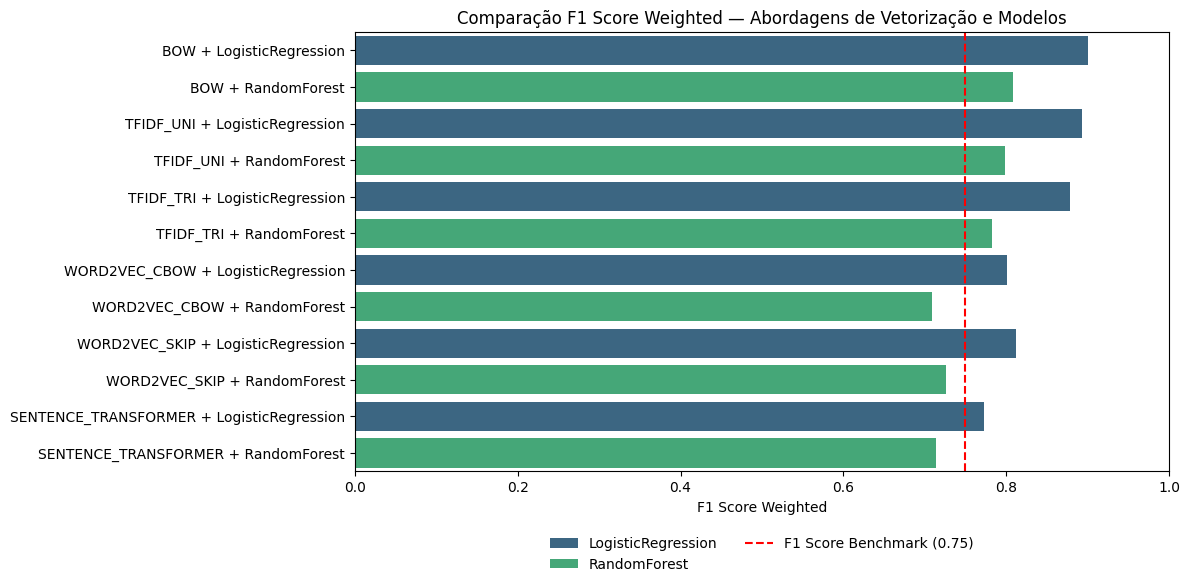

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# 📂 Diretório de saída
BASE_DIR = Path('/content/drive/MyDrive/MBA_NLP/bases_criadas')

# 📌 Carrega resultados
df = pd.read_csv(BASE_DIR / 'relatorio_comparativo_classificacao.csv')

# 🔀 Organiza ordem para clareza
df['Combinação'] = df['Vetorizacao'].str.upper() + ' + ' + df['Modelo']

# 📊 Plot com linha de corte
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df,
    y='Combinação',
    x='F1_Score_Weighted',
    hue='Modelo',      # Define hue explicitamente
    dodge=False,
    palette='viridis'
)

# 🔑 Linha de benchmark 75%
plt.axvline(x=0.75, color='red', linestyle='--', label='F1 Score Benchmark (0.75)')

plt.xlabel('F1 Score Weighted')
plt.ylabel('')
plt.title('Comparação F1 Score Weighted — Abordagens de Vetorização e Modelos')
plt.xlim(0, 1)

# ⚙️ Coloca a legenda abaixo do gráfico
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.12),
    ncol=2,
    frameon=False
)

plt.tight_layout()

# 💾 Salva figura
plt.savefig(BASE_DIR / 'grafico_comparativo_f1score.png', dpi=300)
print(f"✅ Gráfico salvo em: {BASE_DIR / 'grafico_comparativo_f1score.png'}")

plt.show()


# ✅ Conclusão Final — Escolha de Abordagem

Após executar todas as etapas do pipeline de classificação supervisionada, verificou-se que a combinação **Bag of Words (BoW) + Logistic Regression** apresentou o **maior F1 Score Weighted (0.9005)** entre todas as abordagens testadas, incluindo TF-IDF, Word2Vec e Sentence-Transformer.

Isso confirma a hipótese de que, para o conjunto de reclamações textuais curtas, **palavras isoladas já carregam informações discriminativas suficientes**, tornando abordagens mais simples e interpretáveis não apenas adequadas, mas superiores em termos de desempenho.

Assim, **BoW + Logistic Regression** será mantido como baseline para etapas futuras, e as demais abordagens ficam documentadas para análise comparativa ou uso em cenários de maior complexidade.

O gráfico de barras anexo complementa esta evidência de forma visual, permitindo rápida validação do benchmark **F1 Weighted ≥ 75%**, superado com margem significativa.

✅ **Relatório salvo:** `relatorio_comparativo_classificacao.csv`  
✅ **Gráfico salvo:** `grafico_comparativo_f1score.png`  
✅ **Todos os vetores versionados:** `/MBA_NLP/bases_criadas`
